In [1]:
from IPython.display import Code

# Example: Auto-Vectorization for RISC-V Vector-Extension using LLVM

Auto-vectorization is a compiler optimization method, which can by applied on SIMD platforms such as vector processors and DSPs. The RISC-V vector extension which is currently being finalized is a good example of that and already supported by the LLVm toolchain.

## Supported components

**Models:** Any (`aww` and `resnet` used below)

**Frontends:** Any (`tflite` used below)

**Frameworks/Backends:** Any (`tvmaotplus` used below)

**Platforms/Targets:** Any platforms and targets supporting the `vext` or `auto_vectorize` feature (`spike` used below)

**Features:** `vext` or `auto_vectorize` feature have to be enabled/installed

**Toolchains:** `llvm` only (RVV GCC is __not__ stable for Zve32x)

## Prerequisites

If not done already, setup a virtual python environment and install the required packages into it. (See `requirements.txt`)

In [2]:
Code(filename="requirements.txt")

-r ../../requirements.txt
attrs
cloudpickle
decorator
numpy
psutil
scipy
synr
tornado
typing_extensions
tflite

Set up MLonmCU as usual, i.e. initialize an environment and install all required dependencies. Feel free to use the following minimal `environment.yml.j2` template:

In [3]:
Code(filename="environment.yml.j2")

---
# The MLONMCU_HOME is filled in automatically when creating the environment
home: "{{ home_dir }}"
logging:
  level: INFO
  to_file: false
  rotate: false
cleanup:
  auto: true
  keep: 5
# Default locations for certain directoriescan be changed here
# Non-absolute paths will always be threated relative to the MLONMCU_HOME
paths:
  # Where the dependencies are downloaded and installed
  deps: deps
  # If logging to file is used keep logs in this directory
  logs: logs
  # Location where reports and artifacts are written to
  results: results
  # Directory where custom extensions can be integrated
  plugins: plugins
  # Directory for intermediate build products, should be located on a large enough drive
  temp: temp
  # A collection of models which will be used to look for models
  # The paths will be checked in the order defined here stopping at the first match
  # Non-existant paths will be skipped without throwing an error
  models:
    - "{{ home_dir }}/models"
# Here default clone_urls
repos:
  tvm:
    url: "https://github.com/apache/tvm.git"
    ref: a9fcac1a47f4b57c1d9d828c7ed1d77452b02cc5
    options:
      recursive: true
  mlif:
    url: "https://github.com/tum-ei-eda/mlonmcu-sw.git"
    ref: c7b0e7364c232666ebd5a17476181e3ff9a71d70
  spike:
    url: "https://github.com/riscv-software-src/riscv-isa-sim.git"
    ref: 0bc176b3fca43560b9e8586cdbc41cfde073e17a
  spikepk:
    url: "https://github.com/riscv-software-src/riscv-pk.git"
    ref: 7e9b671c0415dfd7b562ac934feb9380075d4aa2
frameworks:
  default: tvm
  tvm:
    enabled: true
    backends:
      default: tvmaotplus
      tvmaotplus:
        enabled: true
        features: {}
    features: {}
frontends:
  tflite:
    enabled: true
    features: []
toolchains:
  gcc: true
  llvm: true
platforms:
  mlif:
    enabled: true
    features:
      debug: true
      vext: true
      auto_vectorize: true
targets:
  default: host_x86
  spike:
    enabled: true
    features:
      vext: true
  host_x86:
    enabled: true
    features: []
postprocesses:
  use: []
vars:
  allow_extensions: false
  runs_per_stage: true
  llvm.dl_url: "https://syncandshare.lrz.de/dl/fi3U4poNbe5DuUgqRsosK4/llvm16.tar.xz"
  riscv_gcc.dl_url: "https://syncandshare.lrz.de/dl/fiD9HnHYkb2V8kNbVQYv242m/rv32gc.tar.gz"
  riscv_gcc.dl_url_vext: "https://syncandshare.lrz.de/dl/fiGp4r3f6SZaC5QyDi6QUiNQ/rv32gcv_new.tar.gz"
flags: {}

Do not forget to set your `MLONMCU_HOME` environment variable first if not using the default location!

## Usage

The following examples use the embedded vextor extension (Zve32x/f) instead of the full vector extension since it is more suitable for MCU-type devices and  suffices for running quantized ML models.

*Warning:* Since Instruction-Set-Simulators (ISS) are used for the following experimenents, we only consider instruction counts instead of real cycle counts (CPI=1). Of course is is not realistic that an actual implementation using VLEN=4096 can finish every operation in a single cycle.

### A) Command Line Interface

As an example, we run `tvmaotplus` backend with two different models on the `spike` target. Since using RISC-V GCC for vectorization seems to lead to some issues, we tell MLonMCU to use LLVM instead (`--config mlif.toolchain=llvm`).

To figure out if auto-vectorization works we first use the `--config vext.vlen=128 --config vext.embedded=1 --feature-gen _ --feature-gen auto_vectorize feature vext` flags.

In [4]:
!python -m mlonmcu.cli.main flow run aww resnet -b tvmaotplus -t spike --config mlif.toolchain=llvm \
        --config vext.vlen=128 --config vext.embedded=1 \
        --feature-gen _ --feature-gen auto_vectorize vext

INFO - Loading environment cache from file
INFO - Successfully initialized cache


INFO - [session-75]  Processing stage LOAD
INFO - [session-75]  Processing stage BUILD


INFO - [session-75]  Processing stage COMPILE


INFO - [session-75]  Processing stage RUN


INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-75] Done processing runs
INFO - Report:
   Session  Run   Model Frontend Framework     Backend Platform Target  Total Cycles  Total Instructions  Total CPI  Validation  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data                Features                                             Config Postprocesses Comment
0       75    0     aww   tflite       tvm  tvmaotplus     mlif  spike      23009668            23009668        1.0        True     124388      59364          56436     67936        16      2512               56852                      []  {'aww.output_shapes': {'Identity': [1, 12]}, '...            []       -
1       75    1     aww   tflite       tvm  tvmaotplus     mlif  spike      21913889            21913889        1.0        True     137270      59364          56424     80830        16      2512               56852  [auto_vectorize, vext]  {'aw

To do some actual comparions, lets run these benchmarks for a set of different VLEN value using several `--config-gen` arguments:

In [5]:
!python -m mlonmcu.cli.main flow run aww resnet -b tvmaotplus -t spike --config mlif.toolchain=llvm \
        --config vext.embedded=1 --feature auto_vectorize --feature vext \
        --config-gen vext.vlen=128 --config-gen vext.vlen=256 --config-gen vext.vlen=512 \
        --config-gen vext.vlen=1024 --config-gen vext.vlen=2048 --config-gen vext.vlen=4096

INFO - Loading environment cache from file
INFO - Successfully initialized cache


INFO - [session-76]  Processing stage LOAD
INFO - [session-76]  Processing stage BUILD


INFO - [session-76]  Processing stage COMPILE


INFO - [session-76]  Processing stage RUN


INFO - All runs completed successfuly!


INFO - Postprocessing session report
INFO - [session-76] Done processing runs
INFO - Report:
    Session  Run   Model Frontend Framework     Backend Platform Target  Total Cycles  Total Instructions  Total CPI  Validation  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data                Features                                             Config Postprocesses Comment
0        76    0     aww   tflite       tvm  tvmaotplus     mlif  spike      21913889            21913889        1.0        True     137270      59364          56424     80830        16      2512               56852  [auto_vectorize, vext]  {'aww.output_shapes': {'Identity': [1, 12]}, '...            []       -
1        76    1     aww   tflite       tvm  tvmaotplus     mlif  spike      21751489            21751489        1.0        True     137270      59364          56424     80830        16      2512               56852  [auto_vectorize, vext]  {'aww.output_shapes': {'Identity': [1, 1

Since the used VLEN is part of the "Config" column is it not shown above. We can fix that using some postprocesses:

In [6]:
!python -m mlonmcu.cli.main flow run aww resnet -b tvmaotplus -t spike --config mlif.toolchain=llvm \
        --config vext.embedded=1 --feature auto_vectorize --feature vext \
        --config-gen vext.vlen=128 --config-gen vext.vlen=256 --config-gen vext.vlen=512 \
        --config-gen vext.vlen=1024 --config-gen vext.vlen=2048 --config-gen vext.vlen=4096 \
        --postprocess config2cols --postprocess filter_cols --postprocess rename_cols \
        --config rename_cols.mapping="{'config_vext.vlen': 'VLEN'}" \
        --config filter_cols.keep="Model,Total Cycles,VLEN"

INFO - Loading environment cache from file
INFO - Successfully initialized cache


INFO - [session-77]  Processing stage LOAD
INFO - [session-77]  Processing stage BUILD


INFO - [session-77]  Processing stage COMPILE


INFO - [session-77]  Processing stage RUN


INFO - [session-77]  Processing stage POSTPROCESS


INFO - All runs completed successfuly!


INFO - Postprocessing session report
INFO - [session-77] Done processing runs
INFO - Report:
     Model  Total Cycles
0      aww      21913889
1      aww      21751489
2      aww      21670289
3      aww      21629689
4      aww      22392189
5      aww      23360909
6   resnet      81789437
7   resnet      81779518
8   resnet      81774526
9   resnet      81831738
10  resnet      81863042
11  resnet      81899651


It might be interesting to visualize the above results in a graph. Check out the "Python Scripting" example below which also covers that.

### B) Python Scripting

Using the Python Scripting API add more degrees of freedom defining benchmarks and allows more powerful trnaformating of the generated results. The following section visualizes the effect of RVV auto-vectorization applied by the LLVM toolchain for different vector lengths.

In [7]:
from tempfile import TemporaryDirectory
from pathlib import Path
import pandas as pd

from mlonmcu.context.context import MlonMcuContext
from mlonmcu.session.run import RunStage

Benchmark Configuration

In [8]:
FRONTEND = "tflite"
MODELS = ["aww", "resnet"]
BACKEND = "tvmaotplus"
PLATFORM = "mlif"
TARGET = "spike"
POSTPROCESSES = ["config2cols", "rename_cols", "filter_cols"]
CONFIG = {
    "mlif.toolchain": "llvm",
    "vext.embedded": True,
    "rename_cols.mapping": {"config_vext.vlen": "VLEN"},
    "filter_cols.keep": ["Model", "Total Cycles", "VLEN"]
}

Initialize and run a multiple benchmarks:

In [9]:
with MlonMcuContext() as context:
    with context.create_session() as session:
        for model in MODELS:
            def helper(session, vlen=0):
                cfg = CONFIG.copy()
                if vlen > 0:
                    cfg["vext.vlen"] = vlen
                run = session.create_run(config=cfg)
                if vlen > 0:
                    run.add_features_by_name(["vext", "auto_vectorize"], context=context)
                run.add_frontend_by_name(FRONTEND, context=context)
                run.add_model_by_name(model, context=context)
                run.add_backend_by_name(BACKEND, context=context)
                run.add_platform_by_name(PLATFORM, context=context)
                run.add_target_by_name(TARGET, context=context)
                run.add_postprocesses_by_name(POSTPROCESSES)
            for vlen in [0, 128, 256, 512, 1024, 2048, 4096]:
                helper(session, vlen)
        session.process_runs(context=context)
        report = session.get_reports()
assert "Failing" not in report.df.columns
report.df

INFO - Loading environment cache from file


INFO - Successfully initialized cache


INFO - [session-78] Processing all stages


INFO - All runs completed successfuly!


INFO - Postprocessing session report


INFO - [session-78] Done processing runs


,Model,Total Cycles,VLEN
0,aww,23009668,NaN
1,aww,21913889,128.0
2,aww,21751489,256.0
3,aww,21670289,512.0
4,aww,21629689,1024.0
5,aww,22392189,2048.0
6,aww,23360909,4096.0
7,resnet,81830098,NaN
8,resnet,81789499,128.0
9,resnet,81779518,256.0


We can transform the dataframe using pandas as follows:

In [10]:
df = report.df
df.fillna(0, inplace=True)
df.set_index('VLEN', inplace=True)
df.index = df.index.map(int).map(str)
firsts = (df.groupby('Model')['Total Cycles'].transform('first'))
df["Factor"] = 1 / (df['Total Cycles'] / firsts)
df

,Model,Total Cycles,Factor
VLEN,,,
0,aww,23009668,1.000000
128,aww,21913889,1.050004
256,aww,21751489,1.057843
512,aww,21670289,1.061807
1024,aww,21629689,1.063800
2048,aww,22392189,1.027576
4096,aww,23360909,0.984965
0,resnet,81830098,1.000000
128,resnet,81789499,1.000496


Finally, we can visualize the achieved speedup for the considered vector lengths:

Model
aww       Axes(0.125,0.11;0.775x0.77)
resnet    Axes(0.125,0.11;0.775x0.77)
Name: Factor, dtype: object

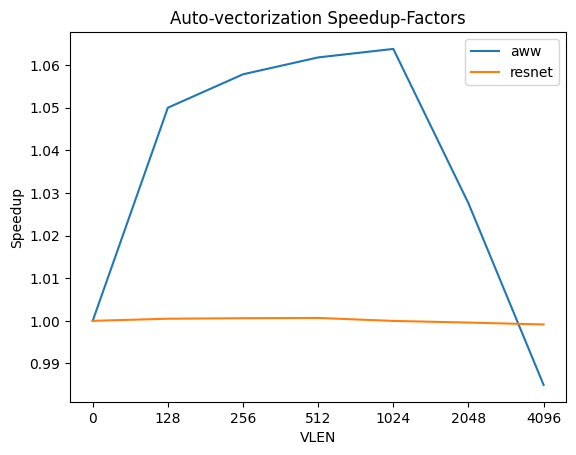

In [11]:
df.groupby('Model')['Factor'].plot(legend=True, title="Auto-vectorization Speedup-Factors", ylabel="Speedup")

The achievable speedup depends heavily on the workload (used model) and too large vector registers might degrade the performance as well in the end.